# Goal: 
## Generating a test 3 Gaussian image centered at the 'same' maximum point of the real data. Then use the fit function to fit that data.
### The advantage is we would know in advance the parameters of the 3 Gaussians to be used as a guess in the fitting process.

In [1]:
%matplotlib inline
from foxsi_optics_calib.psf import psf2d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
from foxsi_optics_calib.psf import PSF2DModel
from astropy.modeling.fitting import LevMarLSQFitter

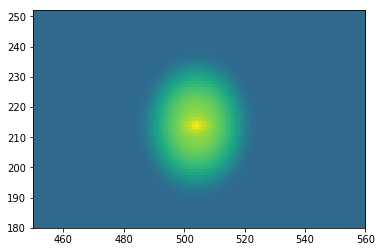

In [69]:
angle = (90 * u.deg).to('rad').value
amplitude = 43717
psf = psf2d(amplitude1=amplitude*0.7, x_stddev1=0.7, y_stddev1=0.7,
                       amplitude2=amplitude*0.3, x_stddev2=1.2, y_stddev2=2,
                       amplitude3=amplitude*0.05, x_stddev3=5, y_stddev3=4,
                       x_mean=504, y_mean=214, theta=angle, offset=0.1)

x, y = np.meshgrid(*[np.arange(v) for v in (1024, 1024)])
simdata = psf(x, y)

plt.imshow(simdata, origin='lower', vmin=1e-4, cmap=plt.cm.viridis, norm=LogNorm())
plt.ylim(180,252)
plt.xlim(450,560)
plt.show()

Reading data:

In [18]:
import astropy.units as u
from foxsi_optics_calib.ccd.ccd import AndorCCDPsfFitImage, AndorCCDPsfImage

focal_length = 2 * u.m

f = '/Volumes/Storage/FOXSI/OpCal/X10Test/data/kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'
d = '/Volumes/Storage/FOXSI/OpCal/X10Test/Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'

psf_img = AndorCCDPsfImage(f, d, focal_length) #for read data
#psffit_img = AndorCCDPsfFitImage(f, d, focal_length) #for read and fit data

Found 6 exposures. Averaging...


Which's the size of the arrays?

In [42]:
print('Real Data size = ',psf_img.xaxis.shape,'Simulated Data size = ',simdata.shape)

Real Data size =  (1024, 1024) Simulated Data size =  (1024, 1024)


Plotting **simulated** vs **real** data:

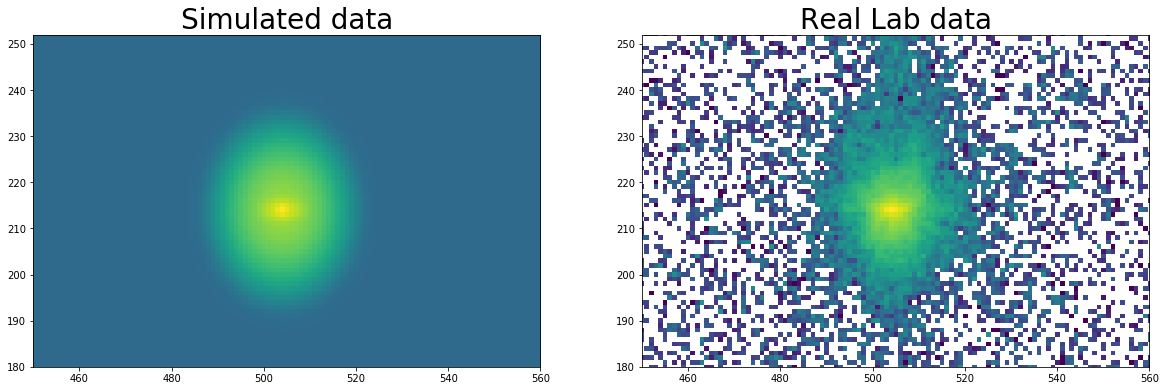

In [70]:
fig = plt.figure(figsize=[20,30])
plt.subplot(1, 2, 1)
plt.imshow(simdata, origin='lower', vmin=1e-4, cmap=plt.cm.viridis, norm=LogNorm())
plt.title('Simulated data',fontsize=28)
plt.ylim(180,252)
plt.xlim(450,560)
plt.subplot(1, 2, 2)
plt.imshow(psf_img.data, origin='lower', cmap=plt.cm.viridis, norm=LogNorm())
plt.title('Real Lab data',fontsize=28)
plt.ylim(180,252)
plt.xlim(450,560)
plt.show()

Creates guess using same values used for making simulated data:

In [71]:
g_init = PSF2DModel(amplitude1=amplitude*0.7, x_stddev1=0.7, y_stddev1=0.7,
                       amplitude2=amplitude*0.3, x_stddev2=1.2, y_stddev2=2,
                       amplitude3=amplitude*0.05, x_stddev3=5, y_stddev3=4,
                       x_mean=504, y_mean=214, theta=angle, offset=0.1)
fit = LevMarLSQFitter()

Trying to fit using *arcsec* coordinates from the original real data:

In [72]:
fitted_model = fit(g_init, psf_img.xaxis.to('arcsec').value,
                           psf_img.yaxis.to('arcsec').value, simdata, maxiter=200)

/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:373: RuntimeWarning: divide by zero encountered in true_divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:374: RuntimeWarning: divide by zero encountered in true_divide
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: divide by zero encountered in true_divide
  c = 0.5 * ((sint2 / xstd2) + (cost2 / ystd2))
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:376: RuntimeWarning: invalid value encountered in add
  return amplitude * np.exp(-((a * xdiff ** 2) + (b * xdiff * ydiff) +
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:374: RuntimeWarning: invalid value encountered in subtract
  b = 0.5 * ((sin2t / x

Since it did not work, what if we now try to fit the gaussians but using the X and Y coordinates? 

In [73]:
fitted_model = fit(g_init, x, y, simdata, maxiter=200)

/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:373: RuntimeWarning: divide by zero encountered in true_divide
  a = 0.5 * ((cost2 / xstd2) + (sint2 / ystd2))
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:374: RuntimeWarning: divide by zero encountered in true_divide
  b = 0.5 * ((sin2t / xstd2) - (sin2t / ystd2))
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: divide by zero encountered in true_divide
  c = 0.5 * ((sint2 / xstd2) + (cost2 / ystd2))
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:376: RuntimeWarning: invalid value encountered in add
  return amplitude * np.exp(-((a * xdiff ** 2) + (b * xdiff * ydiff) +
/Users/Kamilobu/anaconda3/lib/python3.6/site-packages/astropy/modeling/functional_models.py:374: RuntimeWarning: invalid value encountered in subtract
  b = 0.5 * ((sin2t / x

### It still does not work, but why?

In [74]:
print(fit.fit_info['message'])
print("amplitude: {0} {1} {2}".format(fitted_model.amplitude1.value,
                                              fitted_model.amplitude2.value,
                                              fitted_model.amplitude3.value))
print("center: {0}, {1}".format(fitted_model.x_mean.value,
                                        fitted_model.y_mean.value))

Number of calls to function has reached maxfev = 200.
amplitude: 30597.99316556391 12443.629152285217 2177.369190138725
center: 503.9489687874926, 178.53674617746972


In [75]:
print('x_stddev1 = ',fitted_model.x_stddev1)
print('x_stddev2 = ',fitted_model.x_stddev2)
print('x_stddev3 = ',fitted_model.x_stddev3)
print('y_stddev1 = ',fitted_model.y_stddev1)
print('y_stddev2 = ',fitted_model.y_stddev2)
print('y_stddev3 = ',fitted_model.y_stddev3)

x_stddev1 =  Parameter('x_stddev1', value=0.36358605190247606, bounds=(0, None))
x_stddev2 =  Parameter('x_stddev2', value=0.045268333829118025, bounds=(0, None))
x_stddev3 =  Parameter('x_stddev3', value=0.007280686858755193, bounds=(0, None))
y_stddev1 =  Parameter('y_stddev1', value=0.3546802358040675, bounds=(0, None))
y_stddev2 =  Parameter('y_stddev2', value=0.0015121587057090324, bounds=(0, None))
y_stddev3 =  Parameter('y_stddev3', value=0.22724707185802762, bounds=(0, None))
